# Functions and stuff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import json
import time #to delay exectutions

import cmdstanpy
import arviz as az
az.style.use('arviz-darkgrid')
!jupyter nbextension enable --py widgetsnbextension

np.set_printoptions(suppress=True)

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.1.39ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 2.2.1pop0-1628521831-21.10-5dbe6cf is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
cwd = os.getcwd()
stan_directory = '~/.cmdstan/cmdstan-2.29.2'
data_dir = 'data/FK'

In [370]:
def plot_priors(CL, Q, VC, VP, ka) :

    fig, ax = plt.subplots(ncols=5, figsize=(10, 2))
 
    az.plot_density(CL, ax=ax[0], point_estimate='median')
    az.plot_density(Q, ax=ax[1], point_estimate='median')
    az.plot_density(VC, ax=ax[2], point_estimate='median')
    az.plot_density(VP, ax=ax[3], point_estimate='median')
    az.plot_density(ka, ax=ax[4], point_estimate='median') 

    for i in range(5) :
        ax[i].set_title(str(['CL pop', 'Q pop', 'VC pop', 'VP pop', 'ka pop'][i]))
        
    plt.show()
    
    
def plot_compare(prior_list, posterior_list) :

    fig, ax = plt.subplots(ncols=5, figsize=(16, 4))
 
    for i in range(5) :
        line1 = az.plot_density(prior_list[i], ax=ax[i], point_estimate=None, colors=['blue'], shade=.3)
        line2 = az.plot_density(posterior_list[i], ax=ax[i], point_estimate=None, colors=['red'], shade=.3)
        ax[i].set_title(str(['CL pop', 'Q pop', 'VC pop', 'VP pop', 'ka pop'][i]))
    plt.show()

In [359]:

def plot_ppc_mle(mle_vars, nsub, data_dir, data_prefix, t_end=192, figsize=(8, 4)) :

    with open(data_dir + '/' + data_prefix + '.data.json', 'r') as f:
      datajson = json.load(f)

    nt = datajson['nt']
    tPK = np.array(datajson['timePK'])
    cObs = np.array(datajson['cObs'])
    t = np.array(datajson['time'])
    
    fig, ax = plt.subplots(ncols=nsub, figsize=figsize)
    
    for i in range(nsub) :

        ind = i
        PKstart = datajson['startPK'][ind]-1
        PKend = datajson['endPK'][ind]
        start = datajson['start'][ind]-1
        end = datajson['end'][ind]
        
        wt = datajson['weight'][ind]

        ax[i].plot(tPK[PKstart:PKend], mle_vars['cPred_ind'][start:end][0:(PKend-PKstart)], '-', label='pred')
        ax[i].plot(tPK[PKstart:PKend], cObs[PKstart:PKend], 'o-', label='obs')
        ax[i].set_title('ind ' + str(i) + ' | weight = ' + str(np.round(wt, 1)))
        ax[i].legend()

        
        
def plot_ppc_az(az_chains, nsub, figsize=(8, 4)) :
 
    cPred_ind = az_chains.posterior_predictive['cPred_ind']
    cPred_pop = az_chains.posterior_predictive['cPred_pop']
    t = az_chains.observed_data['time']
    tPK = az_chains.observed_data['timePK']

    fig, ax = plt.subplots(ncols=nsub, figsize=figsize) 

    for i in range(nsub) :

        wt = np.array(az_chains.observed_data['weight'][i])
        PKstart = int(az_chains.observed_data['startPK'][i]-1)
        PKend = int(az_chains.observed_data['endPK'][i])
        start = int(az_chains.observed_data['start'][i])
        end = int(az_chains.observed_data['end'][i])

        cPred_ind_i = cPred_ind[:, :, start:end]
        qlow_ind = np.quantile(cPred_ind_i, 0.05, axis=[0,1])
        qhigh_ind = np.quantile(cPred_ind_i, 0.975, axis=[0,1])
        
        cPred_pop_i = cPred_pop[:, :, start:end]
        qlow_pop = np.quantile(cPred_pop_i, 0.05, axis=[0,1])
        qhigh_pop = np.quantile(cPred_pop_i, 0.975, axis=[0,1])

        ax[i].plot(tPK[PKstart:PKend], cPred_ind_i.mean(axis=0).mean(axis=0)[0:(PKend-PKstart)],
                   color='red', label='ind pred') 
        ax[i].fill_between(tPK[PKstart:PKend], 
                           qlow_ind[0:(PKend-PKstart)], 
                           qhigh_ind[0:(PKend-PKstart)], 
                           alpha=0.2, color='red', label='95% CI')
        
        ax[i].plot(tPK[PKstart:PKend], cPred_pop_i.mean(axis=0).mean(axis=0)[0:(PKend-PKstart)],
                   color='blue', label='pop pred') 
        ax[i].fill_between(tPK[PKstart:PKend], 
                           qlow_pop[0:(PKend-PKstart)], 
                           qhigh_pop[0:(PKend-PKstart)], 
                           alpha=0.2, color='blue', label='95% CI')
        
        ax[i].plot(tPK[PKstart:PKend], az_chains.observed_data['cObs'][PKstart:PKend], 
                   '-o', markersize=3, color='black', label='obs')
        

        ax[i].set_title('ind ' + str(i+1) + ' | weight = ' + str(np.round(wt, 1)))
        ax[i].legend()

    plt.show()

# Priors on parameters

**True values :** CL_pop = 10, Q_pop = 15, VC_pop = 35, VP_pop = 105, KA_pop = 2.0

At first, FK_less_info model had very wide priors sd=10 not taking into account the log scale, 
yet mle was still performing alright. Changed these priors were changer to sd of log(5) to be reasonably informative.


More stable and accurate estimation of parameters when changing variance priors. Changed variance priors to $\omega \sim Cauchy(0, 0.5)$ (reduced sd) and $sigma \sim N(0, 0.1)$ (previously Cauchy) and estimation of parameters drastically improved.

### Relatively informative priors

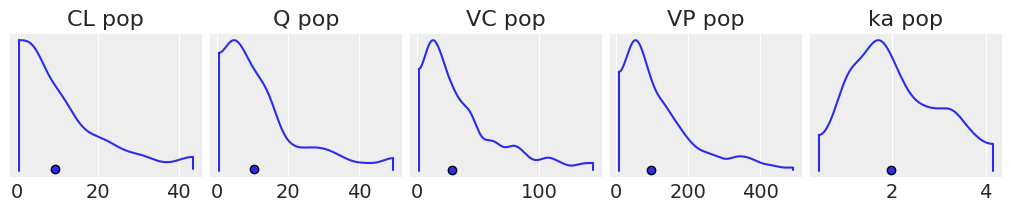

In [144]:
CLpop_prior = np.random.lognormal(mean=np.log(10), sigma=1, size=500)
Qpop_prior = np.random.lognormal(mean=np.log(10), sigma=1, size=500)
VCpop_prior = np.random.lognormal(mean=np.log(30), sigma=1, size=500)
VPpop_prior = np.random.lognormal(mean=np.log(100), sigma=1, size=500)
kapop_prior = np.random.lognormal(mean=np.log(2), sigma=0.5, size=500)

plot_priors(CLpop_prior, Qpop_prior, VCpop_prior, VPpop_prior, kapop_prior)

### Wider priors

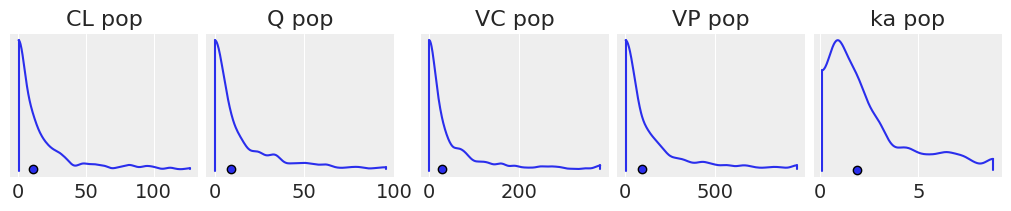

In [146]:
CLpop_prior = np.random.lognormal(mean=np.log(10), sigma=np.log(5), size=500)
Qpop_prior = np.random.lognormal(mean=np.log(10), sigma=np.log(5), size=500)
VCpop_prior = np.random.lognormal(mean=np.log(30), sigma=np.log(5), size=500)
VPpop_prior = np.random.lognormal(mean=np.log(100), sigma=np.log(5), size=500)
kapop_prior = np.random.lognormal(mean=np.log(2), sigma=1, size=500)

plot_priors(CLpop_prior, Qpop_prior, VCpop_prior, VPpop_prior, kapop_prior)

# MLE 

Estimation of parameters is only good with initialization to plausible values

## Two compartments model with 2 subjects

In [354]:
data_prefix = 'fribergKarlsson_2sub'
data_file = data_prefix + '.data.R'
init_file = data_prefix + '.init.R'
! cat $data_dir/$init_file

alpha_pop <- 0.0101418216692458
circ0_pop <- 3.38570855822157
CL_pop <- 23.7137581297759
etaStd <- 
structure(c(0, 0, 0, 0, 0, 0, 0, 0),
.Dim = c(4, 2))
gamma_pop <- 0.198251293850827
ka_pop <- 5.40408010983666
L <- 
structure(c(1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1),
.Dim = c(4, 4))
mtt_pop <- 98.1075415581857
omega <- 
c(0.0516685706720114, 0.0443914128678141, 0.0514490824009778,
0.0651622200414541)
Q_pop <- 26.429664351578
sigma <- 0.2
sigmaNeut <- 0.2
VC_pop <- 58.7592478001658
VP_pop <- 214.882611429478


### MLE with informative priors : almost perfect estimation of parameters and ppc

In [360]:
model = 'FK'
#! cat ./model/$model*.stan
mle_model = cmdstanpy.CmdStanModel(model_name=model, stan_file='model/' + model + '.stan') 

INFO:cmdstanpy:found newer exe file, not recompiling


In [361]:
mle_fit = mle_model.optimize(data=data_dir + '/' + data_file, inits=data_dir+'/'+init_file)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


In [362]:
mle = mle_fit.stan_variables()
print(mle['THETA_pop'], mle['ka_pop'], mle['sigma'])

[ 9.52831 11.6989  36.38    94.0941 ] 2.03035 0.0963517


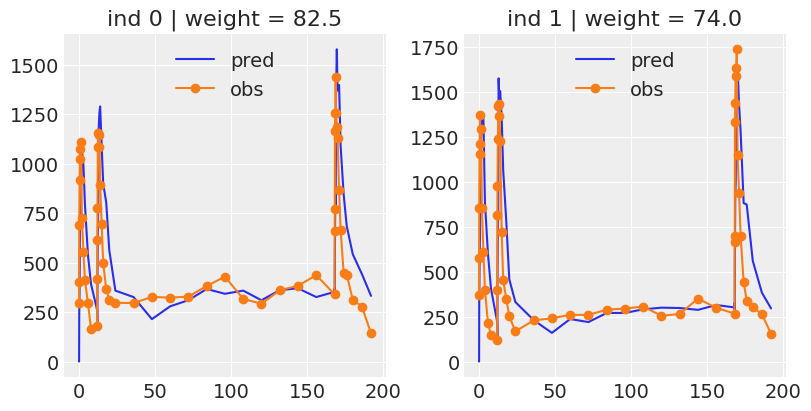

In [363]:
plot_ppc_mle(mle, 2, data_dir, data_prefix)

### MLE with wider priors : almost perfect estimation of parameters and good ppc

In [364]:
model = 'FK_less_info'
mle_model = cmdstanpy.CmdStanModel(model_name=model, stan_file='model/' + model + '.stan') 

INFO:cmdstanpy:found newer exe file, not recompiling


In [365]:
mle_fit = mle_model.optimize(data=data_dir + '/' + data_file, inits=data_dir+'/'+init_file)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


In [366]:
mle = mle_fit.stan_variables()
print(mle['THETA_pop'], mle['ka_pop'], mle['sigma'])

[ 9.52137 11.7727  36.4825  93.7329 ] 2.03122 0.096345


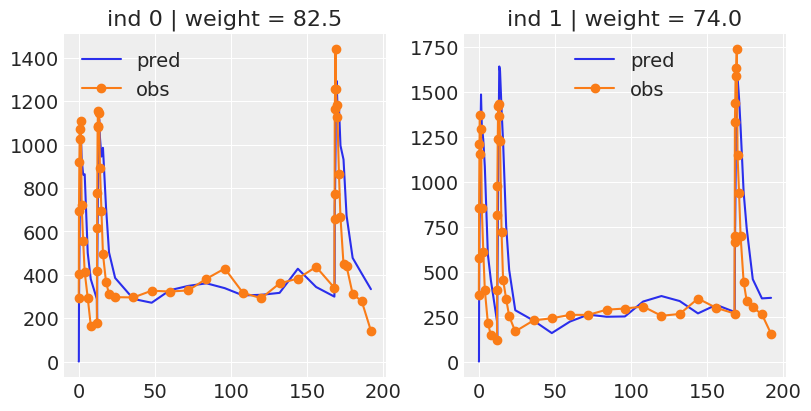

In [367]:
plot_ppc_mle(mle, 2, data_dir, data_prefix)

## Two compartments model with 5 subjects

In [18]:
data_prefix = 'fribergKarlsson_5sub'
data_file = data_prefix + '.data.R'
init_file = data_prefix + '.init.R'
#! cat $data_folder/$data_file

### MLE with informative priors: almost perfect estimation of parameters and good ppc

In [19]:
model = 'FK'
#! cat ./model/$model*.stan
mle_model = cmdstanpy.CmdStanModel(model_name=model, stan_file='model/' + model + '.stan') 

INFO:cmdstanpy:found newer exe file, not recompiling


In [20]:
mle_fit = mle_model.optimize(data=data_dir + '/' + data_file, inits=data_dir+'/'+init_file)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


In [21]:
mle = mle_fit.stan_variables()
print(mle['THETA_pop'], mle['ka_pop'], mle['sigma'])

[  8.78308  14.5066   35.1213  106.876  ] 1.77286 0.0974942


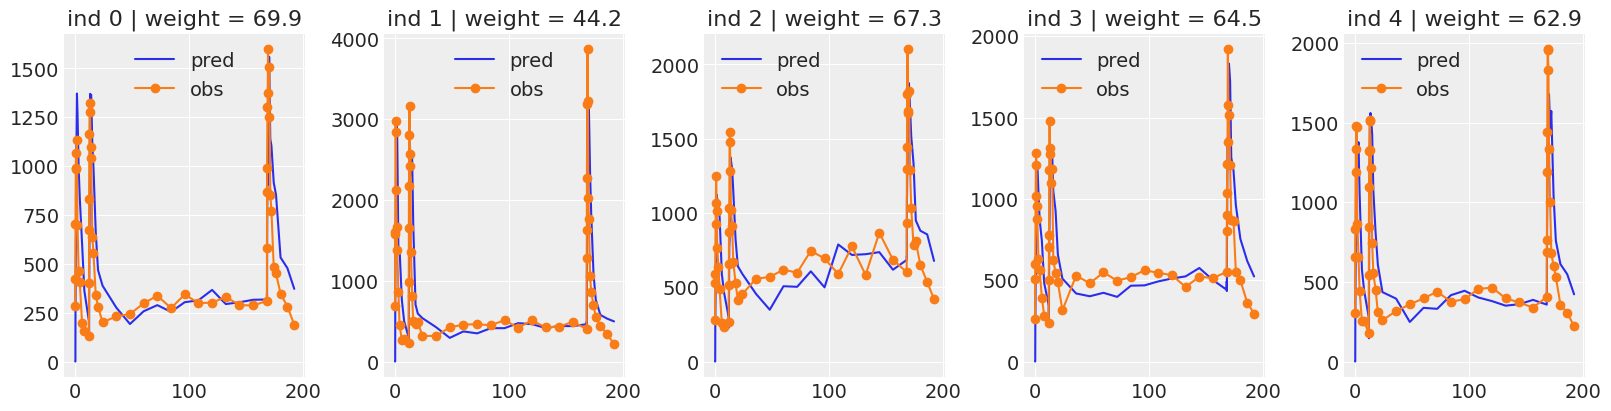

In [22]:
plot_ppc_mle(mle, 5, data_dir, data_prefix, figsize=(16, 4))

### MLE with wider priors: good estimation of parameters and good ppc

In [23]:
model = 'FK_less_info'
#! cat ./model/$model*.stan
mle_model = cmdstanpy.CmdStanModel(model_name=model, stan_file='model/' + model + '.stan') 

INFO:cmdstanpy:found newer exe file, not recompiling


In [24]:
mle_fit = mle_model.optimize(data=data_dir + '/' + data_file, inits=data_dir+'/'+init_file)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


In [25]:
mle = mle_fit.stan_variables()
print(mle['THETA_pop'], mle['ka_pop'], mle['sigma'])

[  8.75182  14.6046   35.326   107.042  ] 1.76842 0.0974941


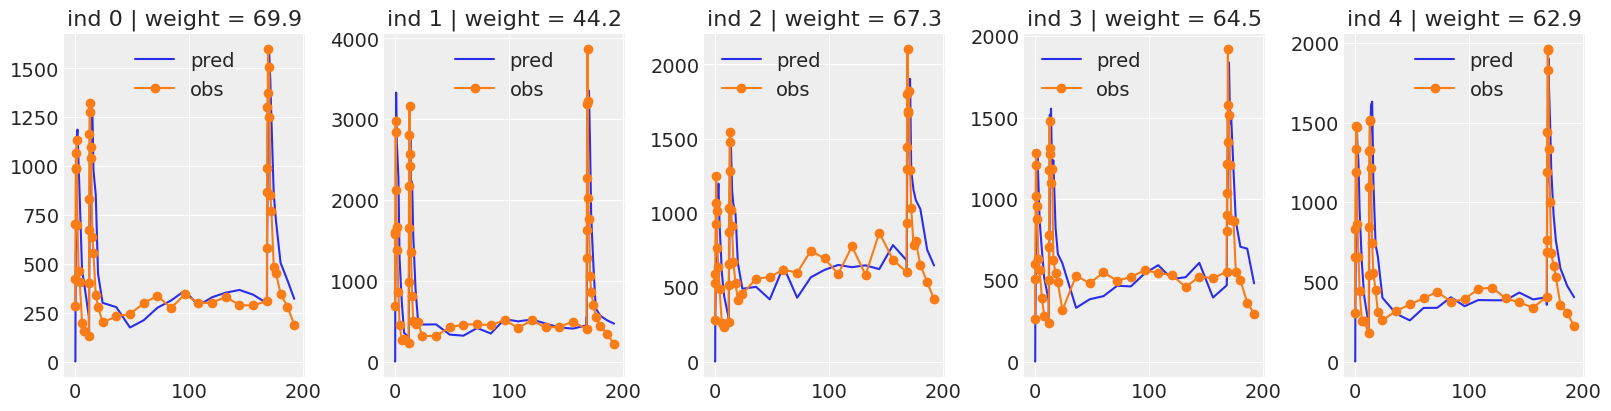

In [26]:
plot_ppc_mle(mle, 5, data_dir, data_prefix, figsize=(16, 4))

# HMC sampling (test with 2 individuals only) 

Tuning initial conditions seems to have influence dramatically the sampling (duingfirst tries markov chains were constant, rhat >>> big)

In [27]:
data_prefix = 'fribergKarlsson_2sub'
data_file = data_prefix + '.data.R'
init_file = data_prefix + '.init.R'
! cat $data_dir/$init_file

alpha_pop <- 0.0101418216692458
circ0_pop <- 3.38570855822157
CL_pop <- 23.7137581297759
etaStd <- 
structure(c(0, 0, 0, 0, 0, 0, 0, 0),
.Dim = c(4, 2))
gamma_pop <- 0.198251293850827
ka_pop <- 5.40408010983666
L <- 
structure(c(1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1),
.Dim = c(4, 4))
mtt_pop <- 98.1075415581857
omega <- 
c(0.0516685706720114, 0.0443914128678141, 0.0514490824009778,
0.0651622200414541)
Q_pop <- 26.429664351578
sigma <- 0.2
sigmaNeut <- 0.2
VC_pop <- 58.7592478001658
VP_pop <- 214.882611429478


## Informative priors

In [41]:
model = 'FK'
#! cat ./model/$model*.stan

In [45]:
hmc_model = cmdstanpy.CmdStanModel(model_name='FKdata', stan_file='model/' + model + '.stan') 

INFO:cmdstanpy:found newer exe file, not recompiling


### 500 + 500 iters

In [46]:
fit_foldername="output_hmc_" + model + '_2sub_' + '1000'
fit_filename="output_hmc_" + model 
output_dir= cwd + "/" + fit_foldername

In [47]:
! mkdir -p $output_dir
#! rm $output_dir/*

In [48]:
hmc_fit = hmc_model.sample(data=data_dir+'/'+data_file, inits=data_dir+'/'+init_file,
                        chains=2, iter_warmup=500, iter_sampling=500, save_warmup=0, 
                        show_progress=True, output_dir=output_dir)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [49]:
hmc_fit.summary().head(6)

Mean    MCSE  StdDev     5%    50%    95%   N_Eff  N_Eff/s  R_hat
name                                                                      
lp__    190.0  0.3700    4.10  180.0  190.0  190.0   130.0     0.62    1.0
CL_pop   10.0  0.1100    2.10    7.6    9.7   14.0   390.0     1.90    1.0
Q_pop    14.0  0.3500    5.90    7.2   12.0   26.0   280.0     1.40    1.0
VC_pop   39.0  0.7600   11.00   27.0   37.0   60.0   220.0     1.10    1.0
VP_pop  110.0  2.2000   41.00   68.0   99.0  170.0   360.0     1.80    1.0
ka_pop    2.0  0.0054    0.17    1.7    2.0    2.3  1000.0     5.10    1.0

In [50]:
chains = az.from_cmdstan(output_dir + '/*' + '.csv', 
                         observed_data= data_dir + '/' + data_file,
                         posterior_predictive=['cPred_pop', 'cPred_ind'])
chains

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

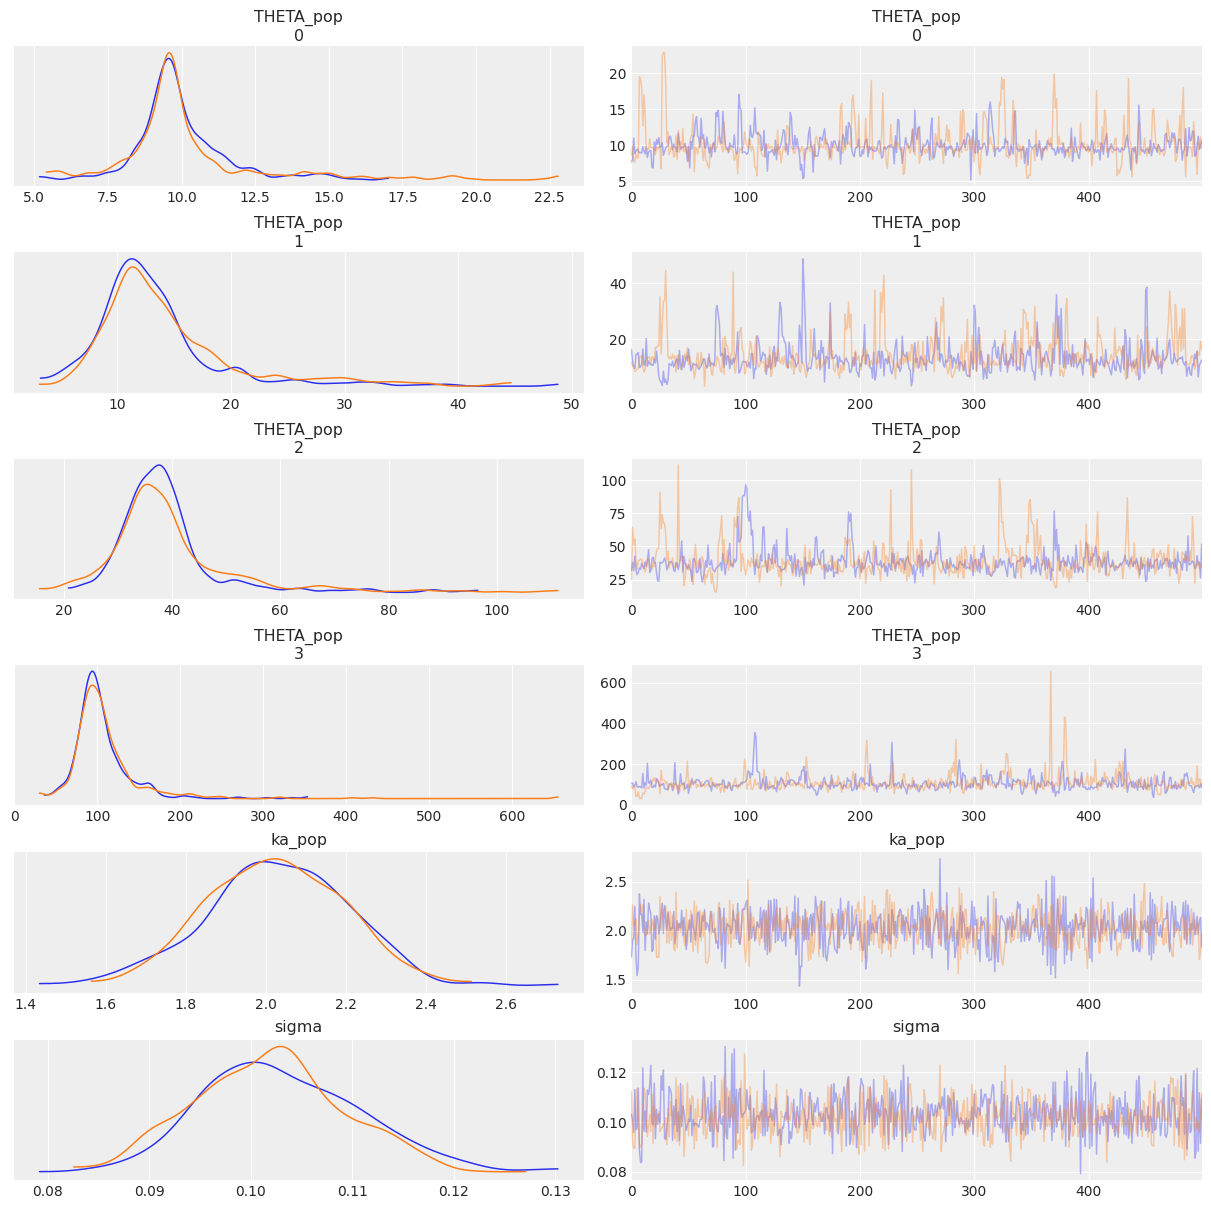

In [51]:
az.plot_trace(chains.posterior, var_names=['THETA_pop', 'ka_pop', 'sigma'], compact=False) ;

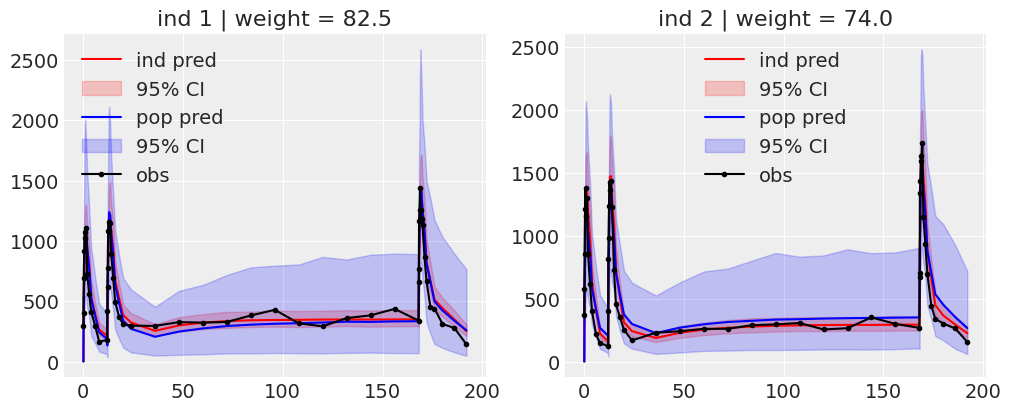

In [56]:
plot_ppc_az(chains, 2, figsize=(10, 4))

### 1000 + 1000 iters and thining = 2

In [57]:
fit_foldername="output_hmc_" + model + '_2sub_2000'
fit_filename="output_hmc_" + model 
output_dir= cwd + "/" + fit_foldername

In [58]:
! mkdir -p $output_dir
#! rm $output_dir/*

rm: cannot remove '/home/tng/Documents/PremiersEssais/Population/twoCpt/output_hmc_FK_2sub_2000/*': No such file or directory


In [59]:
hmc_fit = hmc_model.sample(data=data_dir+'/'+data_file, inits=data_dir+'/'+init_file,
                        chains=2, iter_warmup=1000, iter_sampling=1000, save_warmup=0, thin=2,
                        show_progress=True, output_dir=output_dir)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [60]:
hmc_fit.summary().head(6)

Mean    MCSE  StdDev     5%    50%    95%  N_Eff  N_Eff/s  R_hat
name                                                                     
lp__    190.0  0.1600    4.00  180.0  190.0  190.0  650.0     1.70    1.0
CL_pop    9.7  0.0650    1.40    7.6    9.6   12.0  490.0     1.30    1.0
Q_pop    15.0  0.4600    8.10    7.7   13.0   29.0  300.0     0.81    1.0
VC_pop   39.0  0.4700   10.00   27.0   38.0   59.0  480.0     1.30    1.0
VP_pop  120.0  6.3000   78.00   70.0   98.0  220.0  150.0     0.41    1.0
ka_pop    2.0  0.0061    0.18    1.7    2.0    2.3  910.0     2.40    1.0

In [66]:
chains = az.from_cmdstan(output_dir + '/*' + '.csv', 
                         observed_data= data_dir + '/' + data_file,
                         posterior_predictive=['cPred_pop', 'cPred_ind'])
chains

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

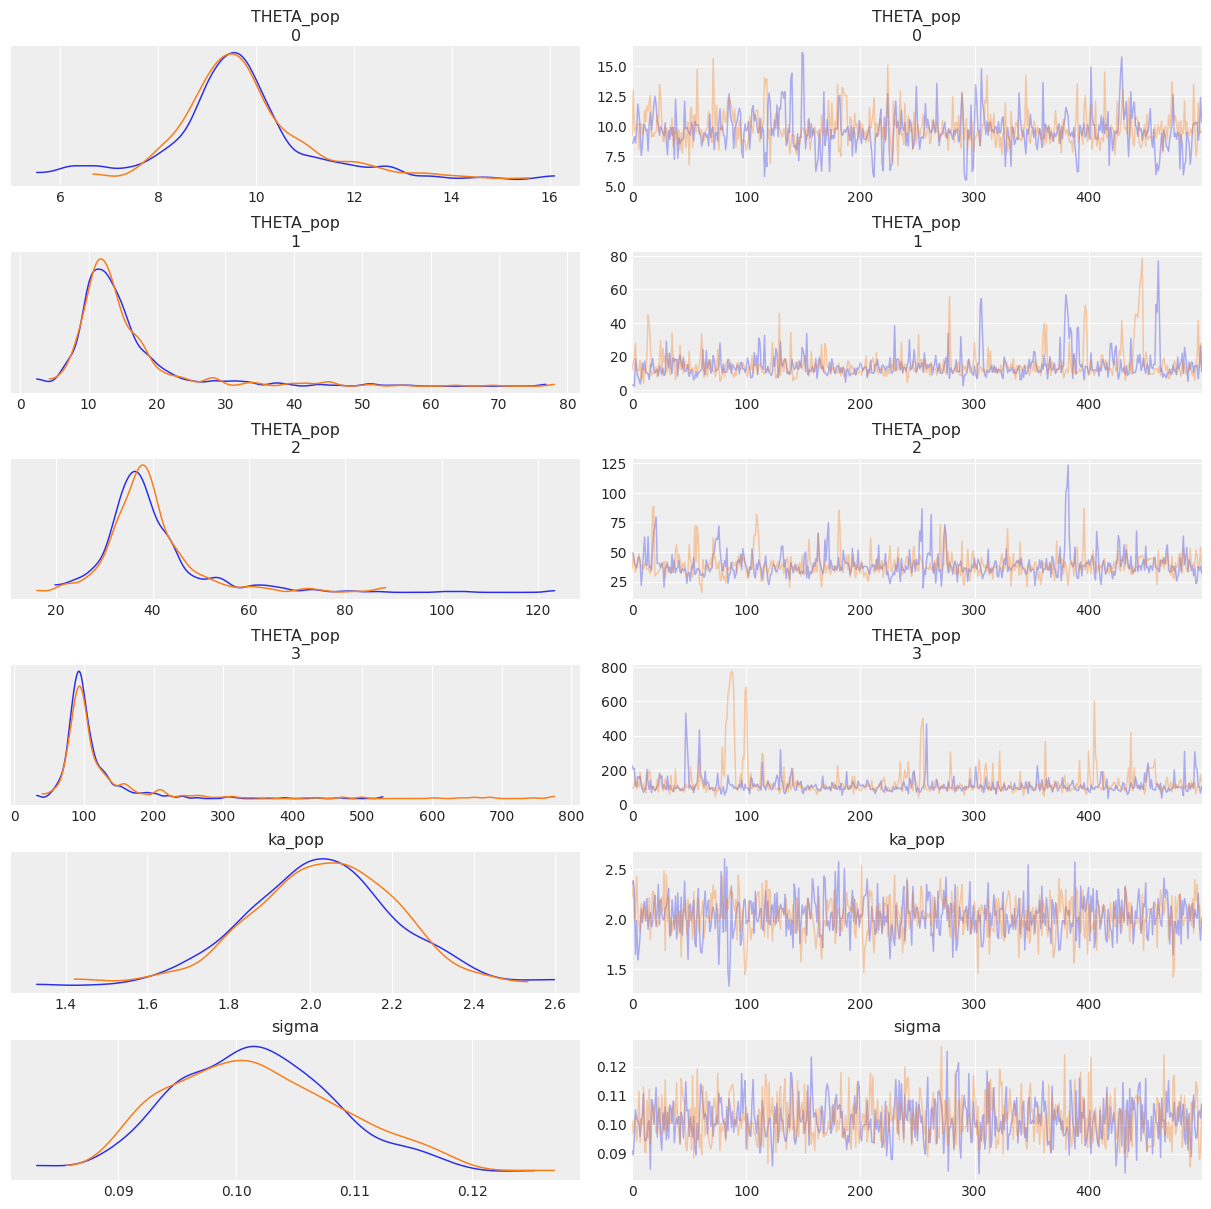

In [67]:
az.plot_trace(chains.posterior, var_names=['THETA_pop', 'ka_pop', 'sigma'], compact=False) ;

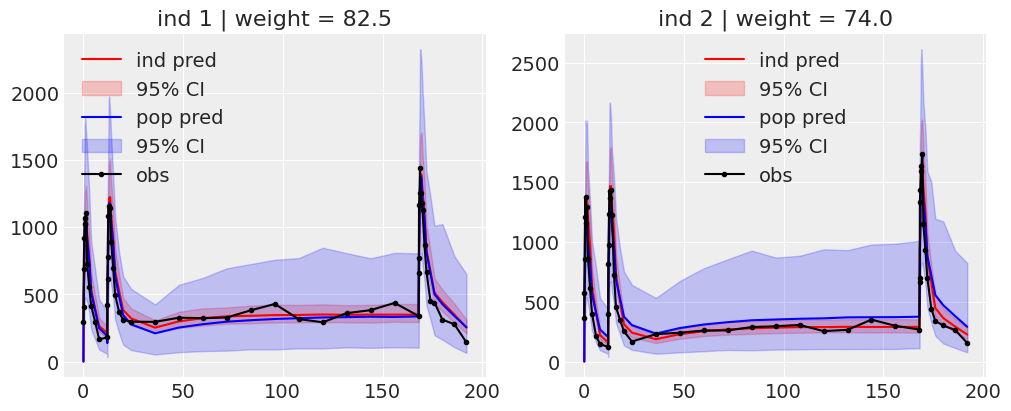

In [68]:
plot_ppc_az(chains, 2, figsize=(10, 4))

## Wider priors

In [70]:
model = 'FK_less_info'
#! cat ./model/$model*.stan
hmc_model = cmdstanpy.CmdStanModel(model_name='FKdata', stan_file='model/' + model + '.stan') 

INFO:cmdstanpy:found newer exe file, not recompiling


### 1000 + 1000 iters and thining = 2

In [71]:
fit_foldername="output_hmc_" + model + '_2sub_2000'
fit_filename="output_hmc_" + model 
output_dir= cwd + "/" + fit_foldername

In [72]:
! mkdir -p $output_dir
#! rm $output_dir/*

rm: cannot remove '/home/tng/Documents/PremiersEssais/Population/twoCpt/output_hmc_FK_less_info_2sub_2000/*': No such file or directory


In [73]:
hmc_fit = hmc_model.sample(data=data_dir+'/'+data_file, inits=data_dir+'/'+init_file,
                        chains=2, iter_warmup=1000, iter_sampling=1000, save_warmup=0, thin=2,
                        show_progress=True, output_dir=output_dir)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [78]:
hmc_fit.summary().head(6)

Mean     MCSE  StdDev     5%    50%    95%  N_Eff  N_Eff/s  R_hat
name                                                                      
lp__    190.0   0.1800     4.0  180.0  190.0  190.0  480.0     0.84    1.0
CL_pop    9.9   0.1100     2.0    7.3    9.6   14.0  340.0     0.60    1.0
Q_pop    19.0   1.8000    26.0    7.6   13.0   45.0  210.0     0.37    1.0
VC_pop   40.0   0.7700    13.0   23.0   37.0   63.0  280.0     0.48    1.0
VP_pop  130.0  11.0000   180.0   65.0   97.0  300.0  260.0     0.45    1.0
ka_pop    2.0   0.0075     0.2    1.7    2.0    2.4  690.0     1.20    1.0

In [79]:
chains = az.from_cmdstan(output_dir + '/*' + '.csv', 
                         observed_data= data_dir + '/' + data_file,
                         posterior_predictive=['cPred_pop', 'cPred_ind'])
chains

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

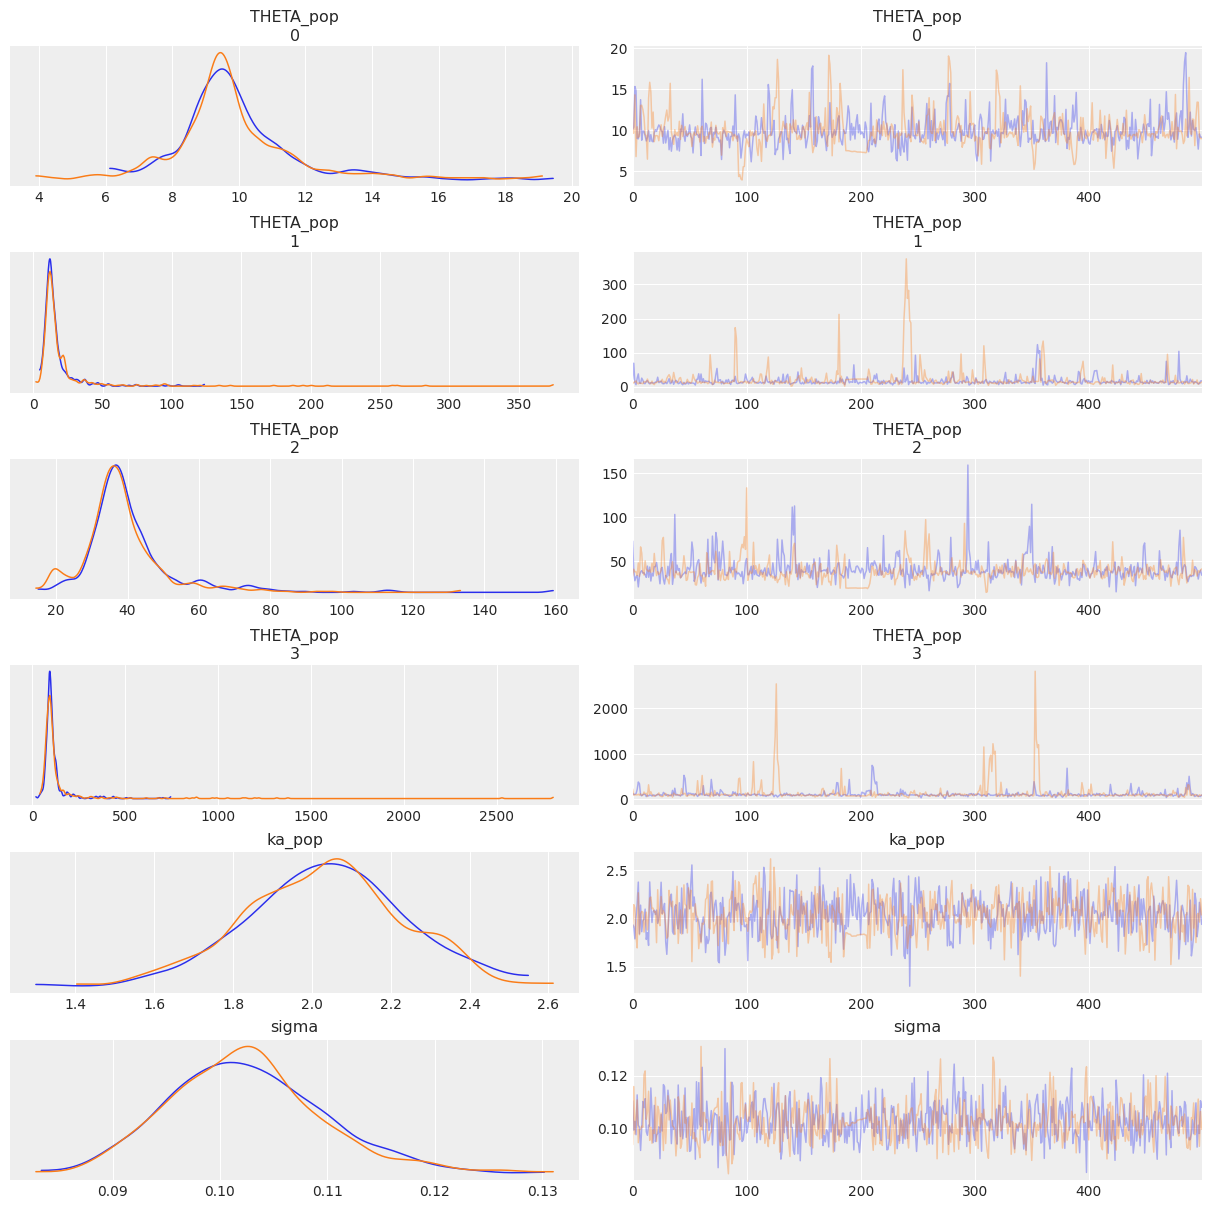

In [80]:
az.plot_trace(chains.posterior, var_names=['THETA_pop', 'ka_pop', 'sigma'], compact=False) ;

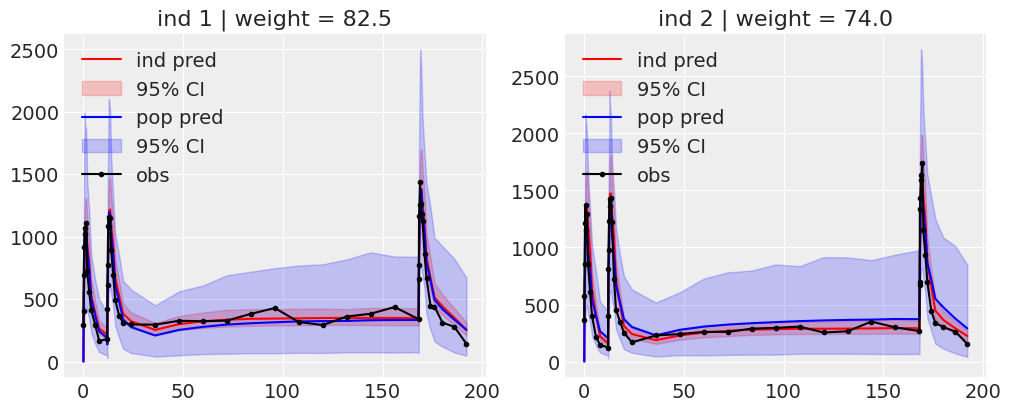

In [83]:
plot_ppc_az(chains, 2, figsize=(10, 4))

# HMC sampling 5 individuals : better estimation of the population parameters and sampling properties

Very informative or wider priors do equally as good

In [90]:
data_prefix = 'fribergKarlsson_5sub'
data_file = data_prefix + '.data.R'
init_file = data_prefix + '.init.R'
! cat $data_dir/$init_file

alpha_pop <- 0.000223853449031671
circ0_pop <- 4.74278208265512
CL_pop <- 19.3663159255587
etaStd <- 
structure(c(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
.Dim = c(4, 5))
gamma_pop <- 0.228010814802148
ka_pop <- 1.17857410082805
L <- 
structure(c(1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1),
.Dim = c(4, 4))
mtt_pop <- 168.925464997872
omega <- 
c(0.108130639699526, 0.0681215860245976, 0.0571593481235776, 0.0230157465139944)
Q_pop <- 41.9695576430994
sigma <- 0.2
sigmaNeut <- 0.2
VC_pop <- 57.7007640264223
VP_pop <- 345.417183008156


In [91]:
model = 'FK'
hmc_model = cmdstanpy.CmdStanModel(model_name='FKdata', stan_file='model/' + model + '.stan') 

INFO:cmdstanpy:found newer exe file, not recompiling


### Very informative priors 1000 + 1000 iters and thining = 2 

Very good estimation of parameters


Better markov chains properties than with 2 individuals

In [92]:
fit_foldername="output_hmc_" + model + '_5sub_2000'
fit_filename="output_hmc_" + model 
output_dir= cwd + "/" + fit_foldername

In [93]:
! mkdir -p $output_dir
#! rm $output_dir/*

In [94]:
hmc_fit = hmc_model.sample(data=data_dir+'/'+data_file, inits=data_dir+'/'+init_file,
                        chains=2, iter_warmup=1000, iter_sampling=1000, save_warmup=0, thin=2,
                        show_progress=True, output_dir=output_dir)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [100]:
hmc_fit.summary().head(6)

Mean   MCSE  StdDev     5%    50%    95%  N_Eff  N_Eff/s  R_hat
name                                                                    
lp__    460.0  0.250    5.30  450.0  460.0  470.0  450.0     0.34    1.0
CL_pop    8.9  0.043    1.00    7.4    8.8   11.0  560.0     0.41    1.0
Q_pop    15.0  0.057    1.40   13.0   15.0   17.0  610.0     0.45    1.0
VC_pop   37.0  0.490    9.10   24.0   36.0   54.0  340.0     0.25    1.0
VP_pop  110.0  0.570   15.00   90.0  110.0  140.0  660.0     0.49    1.0
ka_pop    1.8  0.005    0.14    1.5    1.8    2.0  810.0     0.60    1.0

In [96]:
chains = az.from_cmdstan(output_dir + '/*' + '.csv', 
                         observed_data= data_dir + '/' + data_file,
                         posterior_predictive=['cPred_pop', 'cPred_ind'])
chains

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

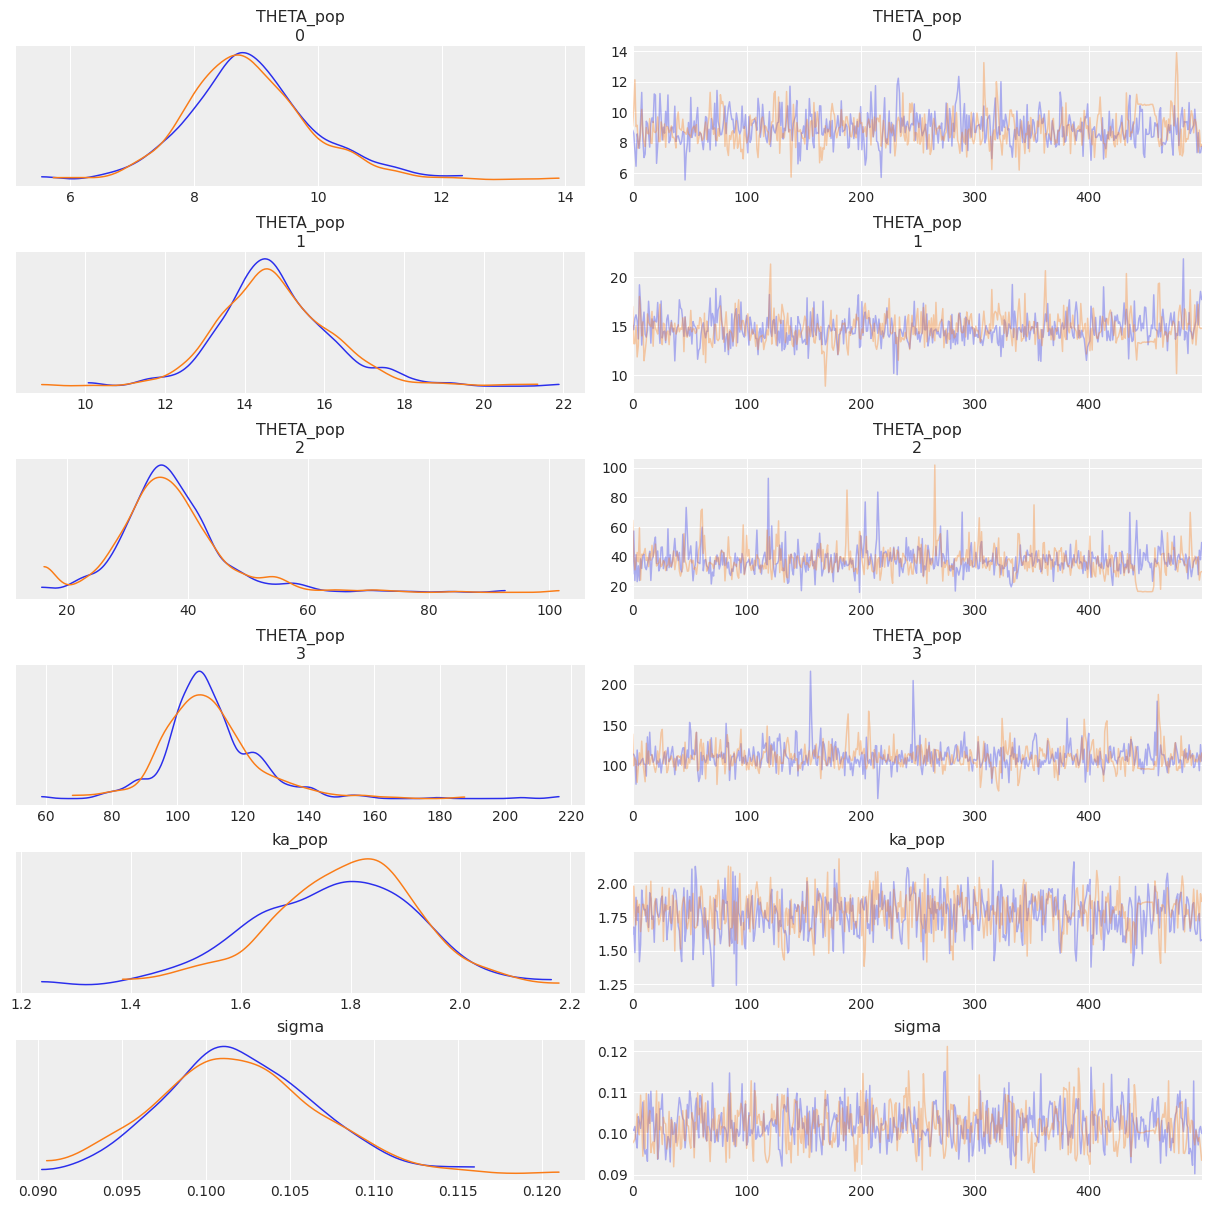

In [97]:
az.plot_trace(chains.posterior, var_names=['THETA_pop', 'ka_pop', 'sigma'], compact=False) ;

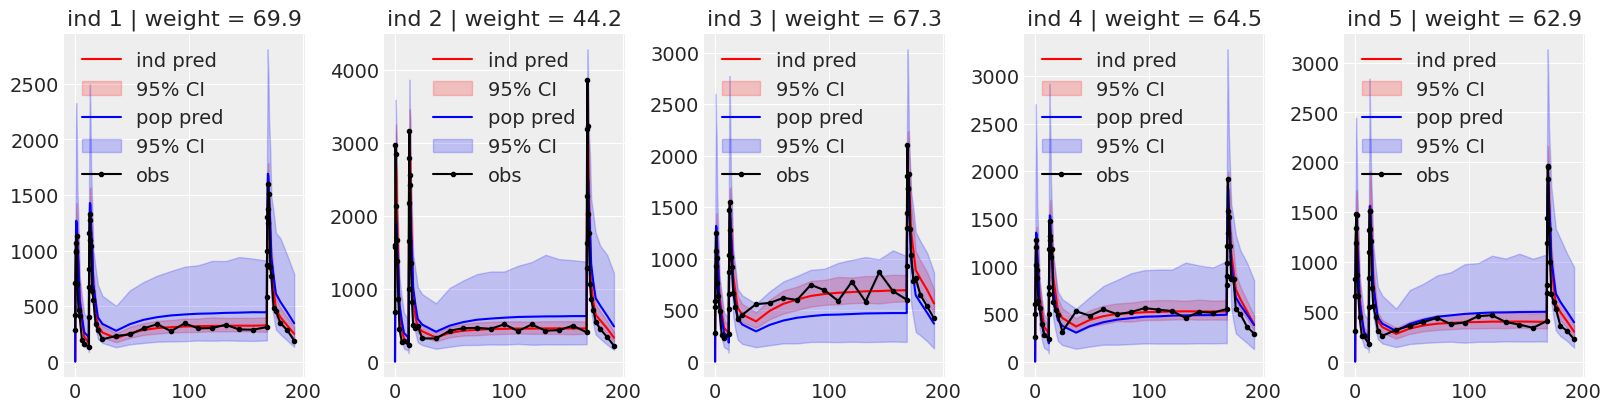

In [98]:
plot_ppc_az(chains, 5, figsize=(16, 4))

### Wider priors, 1000 + 1000 iters and thining = 2 

In [122]:
model = 'FK_less_info'
hmc_model = cmdstanpy.CmdStanModel(model_name='FKdata', stan_file='model/' + model + '.stan') 

INFO:cmdstanpy:found newer exe file, not recompiling


In [123]:
fit_foldername="output_hmc_" + model + '_5sub_2000'
fit_filename="output_hmc_" + model 
output_dir= cwd + "/" + fit_foldername

In [103]:
! mkdir -p $output_dir
#! rm $output_dir/*

rm: cannot remove '/home/tng/Documents/PremiersEssais/Population/twoCpt/output_hmc_FK_less_info5sub_2000/*': No such file or directory


In [104]:
hmc_fit = hmc_model.sample(data=data_dir+'/'+data_file, inits=data_dir+'/'+init_file,
                        chains=2, iter_warmup=1000, iter_sampling=1000, save_warmup=0, thin=2,
                        show_progress=True, output_dir=output_dir)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [109]:
hmc_fit.summary().head(6)

Mean    MCSE  StdDev     5%    50%    95%  N_Eff  N_Eff/s  R_hat
name                                                                     
lp__    460.0  0.2200    5.10  450.0  460.0  470.0  540.0     0.41    1.0
CL_pop    8.9  0.0540    1.10    7.3    8.8   11.0  390.0     0.30    1.0
Q_pop    15.0  0.0740    1.60   13.0   15.0   18.0  500.0     0.38    1.0
VC_pop   38.0  0.6100   11.00   26.0   37.0   58.0  300.0     0.23    1.0
VP_pop  110.0  0.6700   15.00   90.0  110.0  130.0  510.0     0.39    1.0
ka_pop    1.8  0.0053    0.15    1.5    1.8    2.0  790.0     0.60    1.0

In [124]:
chains = az.from_cmdstan(output_dir + '/*' + '.csv', 
                         observed_data= data_dir + '/' + data_file,
                         posterior_predictive=['cPred_pop', 'cPred_ind'])
chains

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

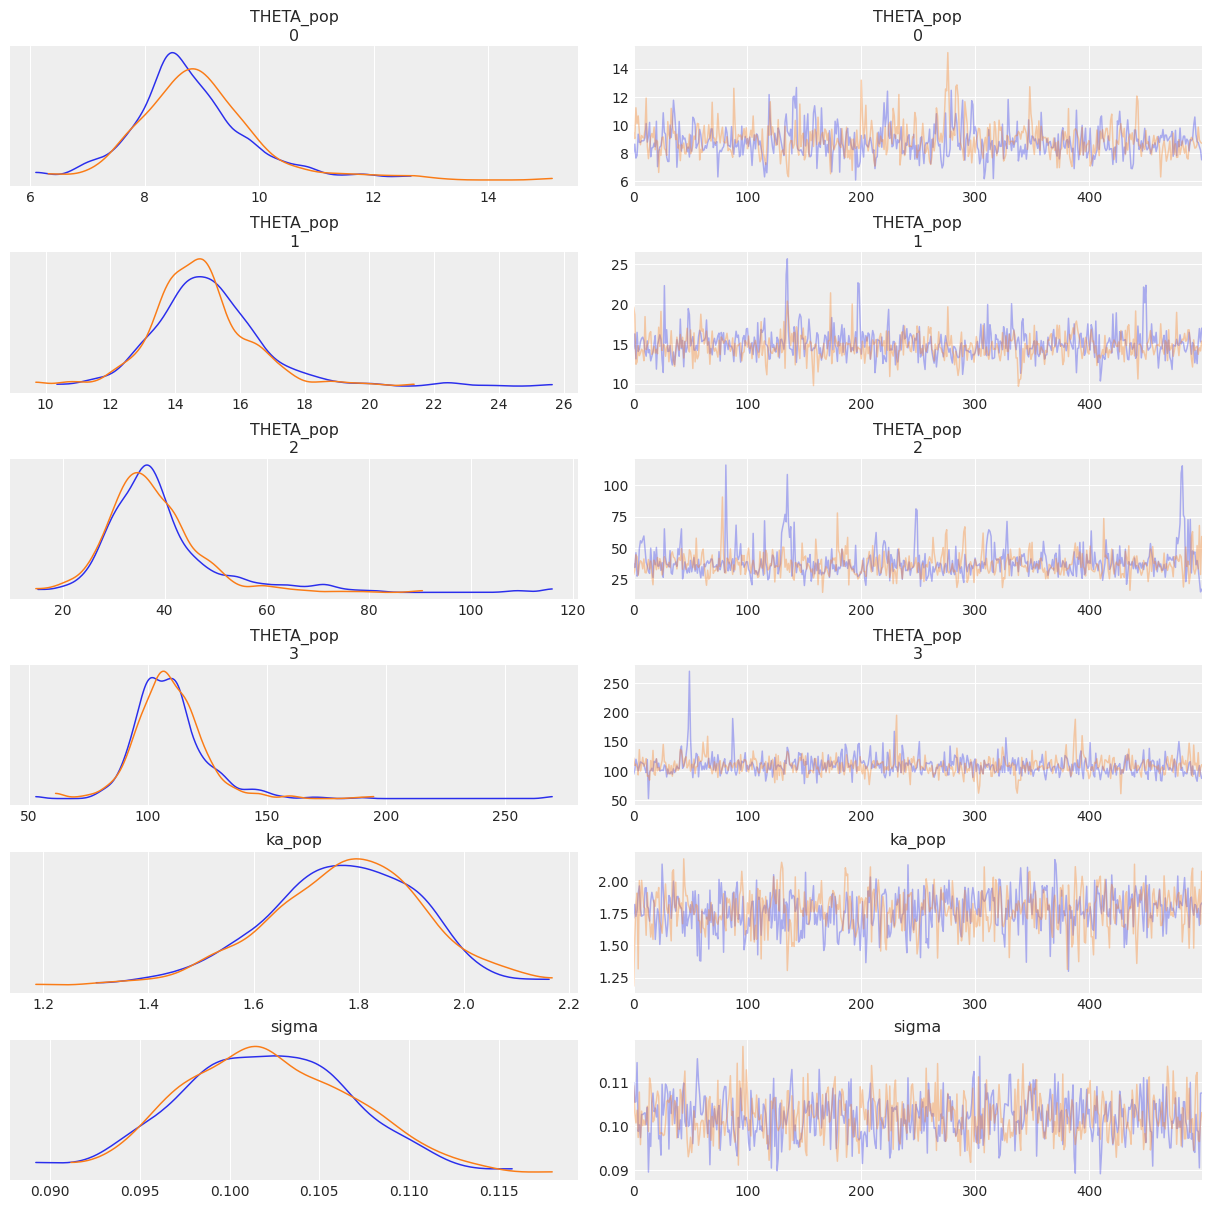

In [115]:
az.plot_trace(chains.posterior, var_names=['THETA_pop', 'ka_pop', 'sigma'], compact=False) ;

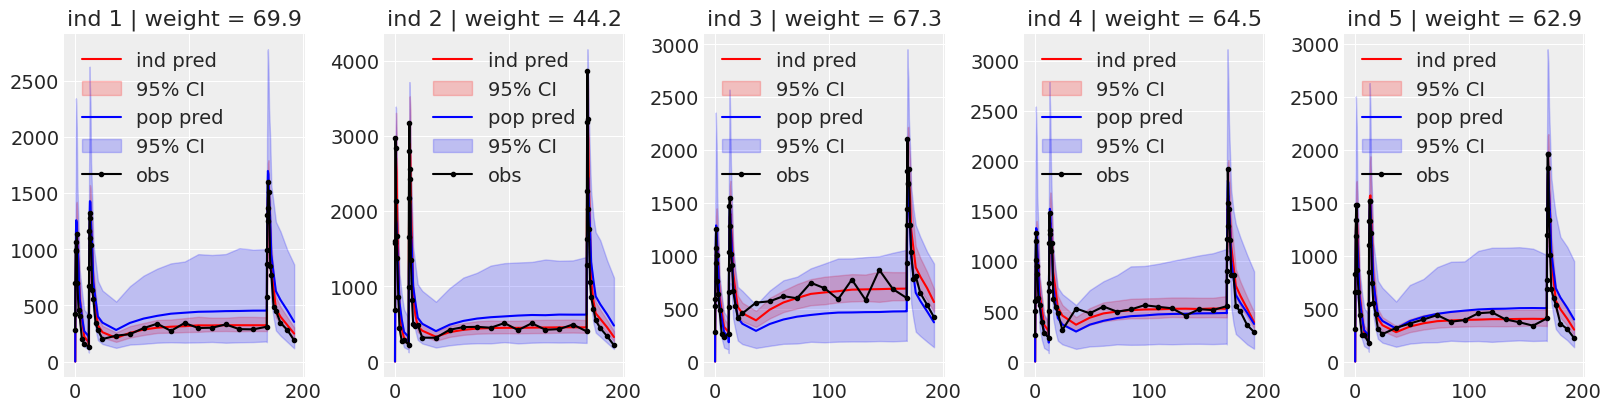

In [244]:
plot_ppc_az(chains, 5, figsize=(16, 4))

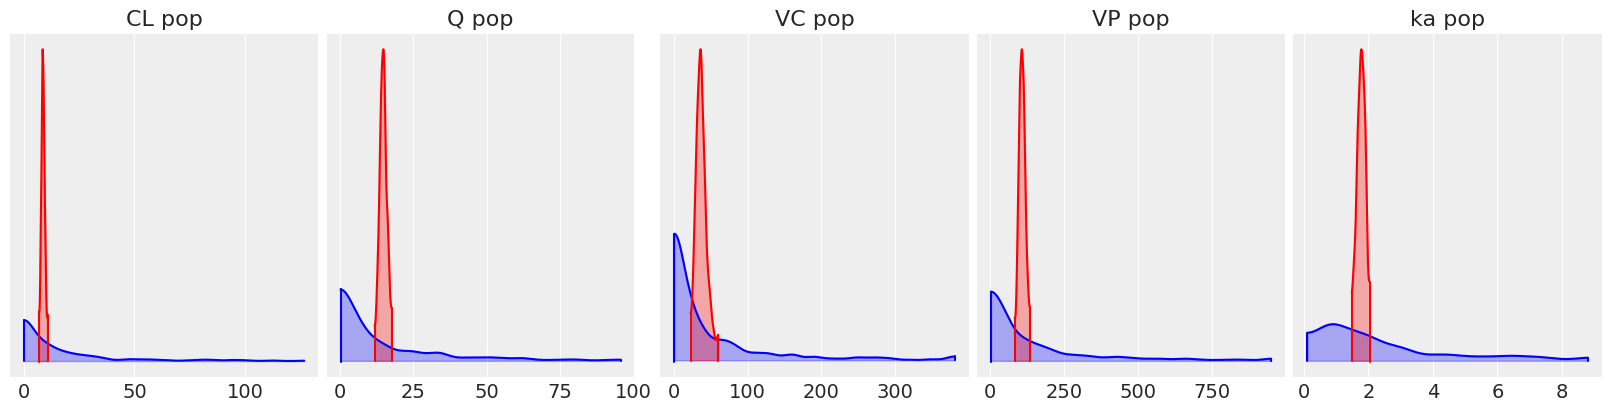

In [371]:
theta_pop = [chains.posterior['THETA_pop'][:, :, i].values for i in range(4)]
theta_pop.append([])
theta_pop[4] = chains.posterior['ka_pop'].values

plot_compare([CLpop_prior, Qpop_prior, VCpop_prior, VPpop_prior, kapop_prior], theta_pop)